# Computational Methods in Finance Case Study 2

#### Timothée Roques - tpr2114

03/12/2023

In [2]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpmath import nsum, exp, inf
import scipy.special as sc
#from BMS import BMS_price, BMS_delta
import time

Now that we have an overview of how to solve the PIDE, we shall use explicit-implicit finite difference scheme, but first, let us set some given parameters and derived functions for this problem:

In [18]:
S = 1900
K = 2000
Bound = 2200
rate = 0.0025
div = 0.015
T = 1/2
sig = 0.25
nu = 0.31
theta = -0.25
Y = 0.4
alpha = Y

N = 1000
M = 30

xmin = 900
xmax = Bound

Dx = (np.log(xmax)-np.log(xmin))/N
Dt = T/M

<br>
Let us compute once and for all and store the different g1 and g2 values for all the steps:

In [19]:
lambda_n = math.sqrt(theta * theta / (sig**4) + 2 / (nu * sig**2)) + theta / (sig **2)
lambda_p = math.sqrt(theta * theta / (sig**4) + 2 / (nu * sig**2)) - theta / (sig **2)

def g1(x):
    return integrate.quad(lambda z: np.exp(-z)/(z**alpha),x,np.inf)[0]
def g2(x):
    return integrate.quad(lambda z: np.exp(-z)/z**(alpha+1),x,np.inf)[0]
def sigma(e):
    pos = 1/nu*lambda_p**(Y-2)*(-(e*lambda_p)**(1-Y)*np.exp(-e*lambda_p) + (1-Y)*(g1(0)-g1(lambda_p*e)))
    neg = 1/nu*lambda_n**(Y-2)*(-(e*lambda_n)**(1-Y)*np.exp(-e*lambda_p) + (1-Y)*(g1(0)-g1(lambda_n*e)))
    return pos + neg
def omeg(e):
    pos = (lambda_p**Y*g2(lambda_p*e)-(lambda_p-1)**Y*g2((lambda_p-1)*e))/nu
    neg = (lambda_n**Y*g2(lambda_n*e)-(lambda_n-1)**Y*g2((lambda_n+1)*e))/nu
    return pos + neg

g1_neg_diff = [0]
g1_pos_diff = [0]
g2_neg_diff = [0]
g2_pos_diff = [0]

for k in range(1,N+1):
    g1_neg_diff.append(g1(k*Dx*lambda_n)-g1((k+1)*Dx*lambda_n))
    g1_pos_diff.append(g1(k*Dx*lambda_p)-g1((k+1)*Dx*lambda_p))
    g2_neg_diff.append(g2(k*Dx*lambda_n)-g2((k+1)*Dx*lambda_n))
    g2_pos_diff.append(g2(k*Dx*lambda_p)-g2((k+1)*Dx*lambda_p))

In [20]:
def tridiag(LL, DD, UU, B, NN):
    L = np.empty(NN+1)
    D = np.empty(NN+1)
    U = np.empty(NN+1)
    for i in range(1,NN+1):
        L[i] = LL[i]
        D[i] = DD[i]
        U[i] = UU[i]
    for i in range(NN-1, 0, -1):
        Xmult = U[i] / D[i+1]
        D[i] = D[i] - Xmult * L[i+1]
        B[i] = B[i] - Xmult * B[i+1]
    B[1] = B[1] / D[1]
    Ic = 1
    for i in range(Ic+1, NN+1):
        B[i] = (B[i] - L[i] * B[i-1]) / D[i]
    return 

In [21]:

start_time = time.time()

L = np.empty((N))
U = np.empty((N))
D = np.empty((N))
B = np.empty((N))


exp_n = np.zeros(N)
exp_p = np.zeros(N)

ei_n = np.zeros(N)
ei_p = np.zeros(N)

A = np.zeros(M)
r = np.zeros(M)
q = np.zeros(M)

omega = np.log(1-theta*nu-sig*sig*nu/2)/nu

cn = Dt/(lambda_n*nu*Dx)
cp = Dt/(lambda_p*nu*Dx)

c = Dt/nu

Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx)

    
x = np.empty(N+1)
W = np.empty(N+1)

for i in range(N+1):
    x[i] = np.log(xmin)+i*Dx
    if i == N:
        W[i] = 0
    else:
        if np.exp(x[i]) > K:
            W[i] = np.exp(x[i])-K
        else:
            W[i] = 0.0

for j in range(M-1, -1, -1):
    r[j] = rate
    q[j] = div
    A[j] = (r[j]-q[j]+omega)*Dt/Dx
    for i in range(1, N):
        B[i] = W[i]

    for i in range(1, N):
        if i == 1:
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
        elif i == N-1:
            L[i] = A[j] - Bn
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        else:
            L[i] =  A[j] - Bn
            D[i] =  1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        B[i] += K*lambda_n**Y*g2(i*Dx*lambda_n) -\
        np.exp(x[i])*(lambda_n+1)**Y*g2(i*Dx*(lambda_n+1))

    tridiag(L,D,U,W,N-1)
    

ir = 0
for i in range(N):
    if x[i] > np.log(S):
        ir = i 
        print(x[i])
        print(W[i])
        break

UOC = (W[ir]-W[ir-1])*(np.log(S)-x[ir-1])/Dx+ W[ir-1]



print("Option via explicit-implicit Finite Difference scheme: for strike %s the option premium \
is %6.4f" % (2000,UOC))
elapsed_time = time.time() - start_time
print('FFT execution time was %0.5f seconds' % elapsed_time)


7.549626507678783
1.1621574392763785
Option via explicit-implicit Finite Difference scheme: for strike 2000 the option premium is 1.1645
FFT execution time was 190.10058 seconds


In [8]:

start_time = time.time()

L = np.empty((N))
U = np.empty((N))
D = np.empty((N))
B = np.empty((N))


exp_n = np.zeros(N)
exp_p = np.zeros(N)

ei_n = np.zeros(N)
ei_p = np.zeros(N)

A = np.zeros(M)
r = np.zeros(M)
q = np.zeros(M)

omega = np.log(1-theta*nu-sig*sig*nu/2)/nu

cn = Dt/(lambda_n*nu*Dx)
cp = Dt/(lambda_p*nu*Dx)

c = Dt/nu

Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx)

def sigma_2(Y,Dx, lambda_p, lambda_n,v):
    #sig = integrate.quad(lambda y: y**2*k(y), -np.inf, -dx)[0]
    #sig += integrate.quad(lambda y: y**2*k(y), dx, np.inf)[0] 
    
    sig = (-(lambda_p*Dx)**(1-Y)*np.exp(-lambda_p*Dx)+(1-Y)*(g1(0)-g1(lambda_p*Dx)))*lambda_p**(Y-2)/v
    sig+= (-(lambda_n*Dx)**(1-Y)*np.exp(-lambda_n*Dx)+(1-Y)*(g1(0)-g1(lambda_n*Dx)))*lambda_n**(Y-2)/v
    
    return sig


Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
print(Bn)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx) # sur de la formule 
print(Bp)
#Bp is for U
sigma2_dx = sigma_2(Y,Dx, lambda_p, lambda_n,nu)
Bp  = sigma2_dx*Dt *(1/(2*Dx**2)-1/(2*Dx))
print(Bp)          
#Bn is for L
Bn  = sigma2_dx*Dt *(1/(2*Dx**2)+1/(2*Dx))
print(Bn)
    
x = np.empty(N+1)
W = np.empty(N+1)
Wmatrix=[]

for i in range(N+1):
    x[i] = np.log(xmin)+i*Dx
    if i == N:
        W[i] = 0
    else:
        if np.exp(x[i]) > K:
            W[i] = np.exp(x[i])-K
        else:
            W[i] = 0.0

Wmatrix.append(W.tolist())

for j in range(M-1, -1, -1):
    r[j] = rate
    q[j] = div
    A[j] = (r[j]-q[j]+omega)*Dt/Dx
    for i in range(1, N):
        B[i] = W[i]

    for i in range(1, N):
        if i == 1:
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
        elif i == N-1:
            L[i] = A[j] - Bn
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        else:
            L[i] =  A[j] - Bn
            D[i] =  1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        B[i] += K*lambda_n**Y*g2(i*Dx*lambda_n) -\
        np.exp(x[i])*(lambda_n+1)**Y*g2(i*Dx*(lambda_n+1))

    tridiag(L,D,U,W,N-1)
    Wmatrix.append(W.tolist())

ir = 0
for i in range(N):
    if x[i] > np.log(S):
        ir = i 
        break

UOC = (W[ir]-W[ir-1])*(np.log(S)-x[ir-1])/Dx+ W[ir-1]



print("Option via explicit-implicit Finite Difference scheme: for strike %s the option premium \
is %6.4f" % (2000,UOC))
elapsed_time = time.time() - start_time
print('Execution time was %0.5f seconds' % elapsed_time)


0.05365849328638006
0.05353749040332997
0.6662853693863283
0.6670386726765051
Option via explicit-implicit Finite Difference scheme: for strike 2000 the option premium is 3.6524
Execution time was 63.35165 seconds


1001
51
(31, 801)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (51, 1001) and arg 2 with shape (31, 801).

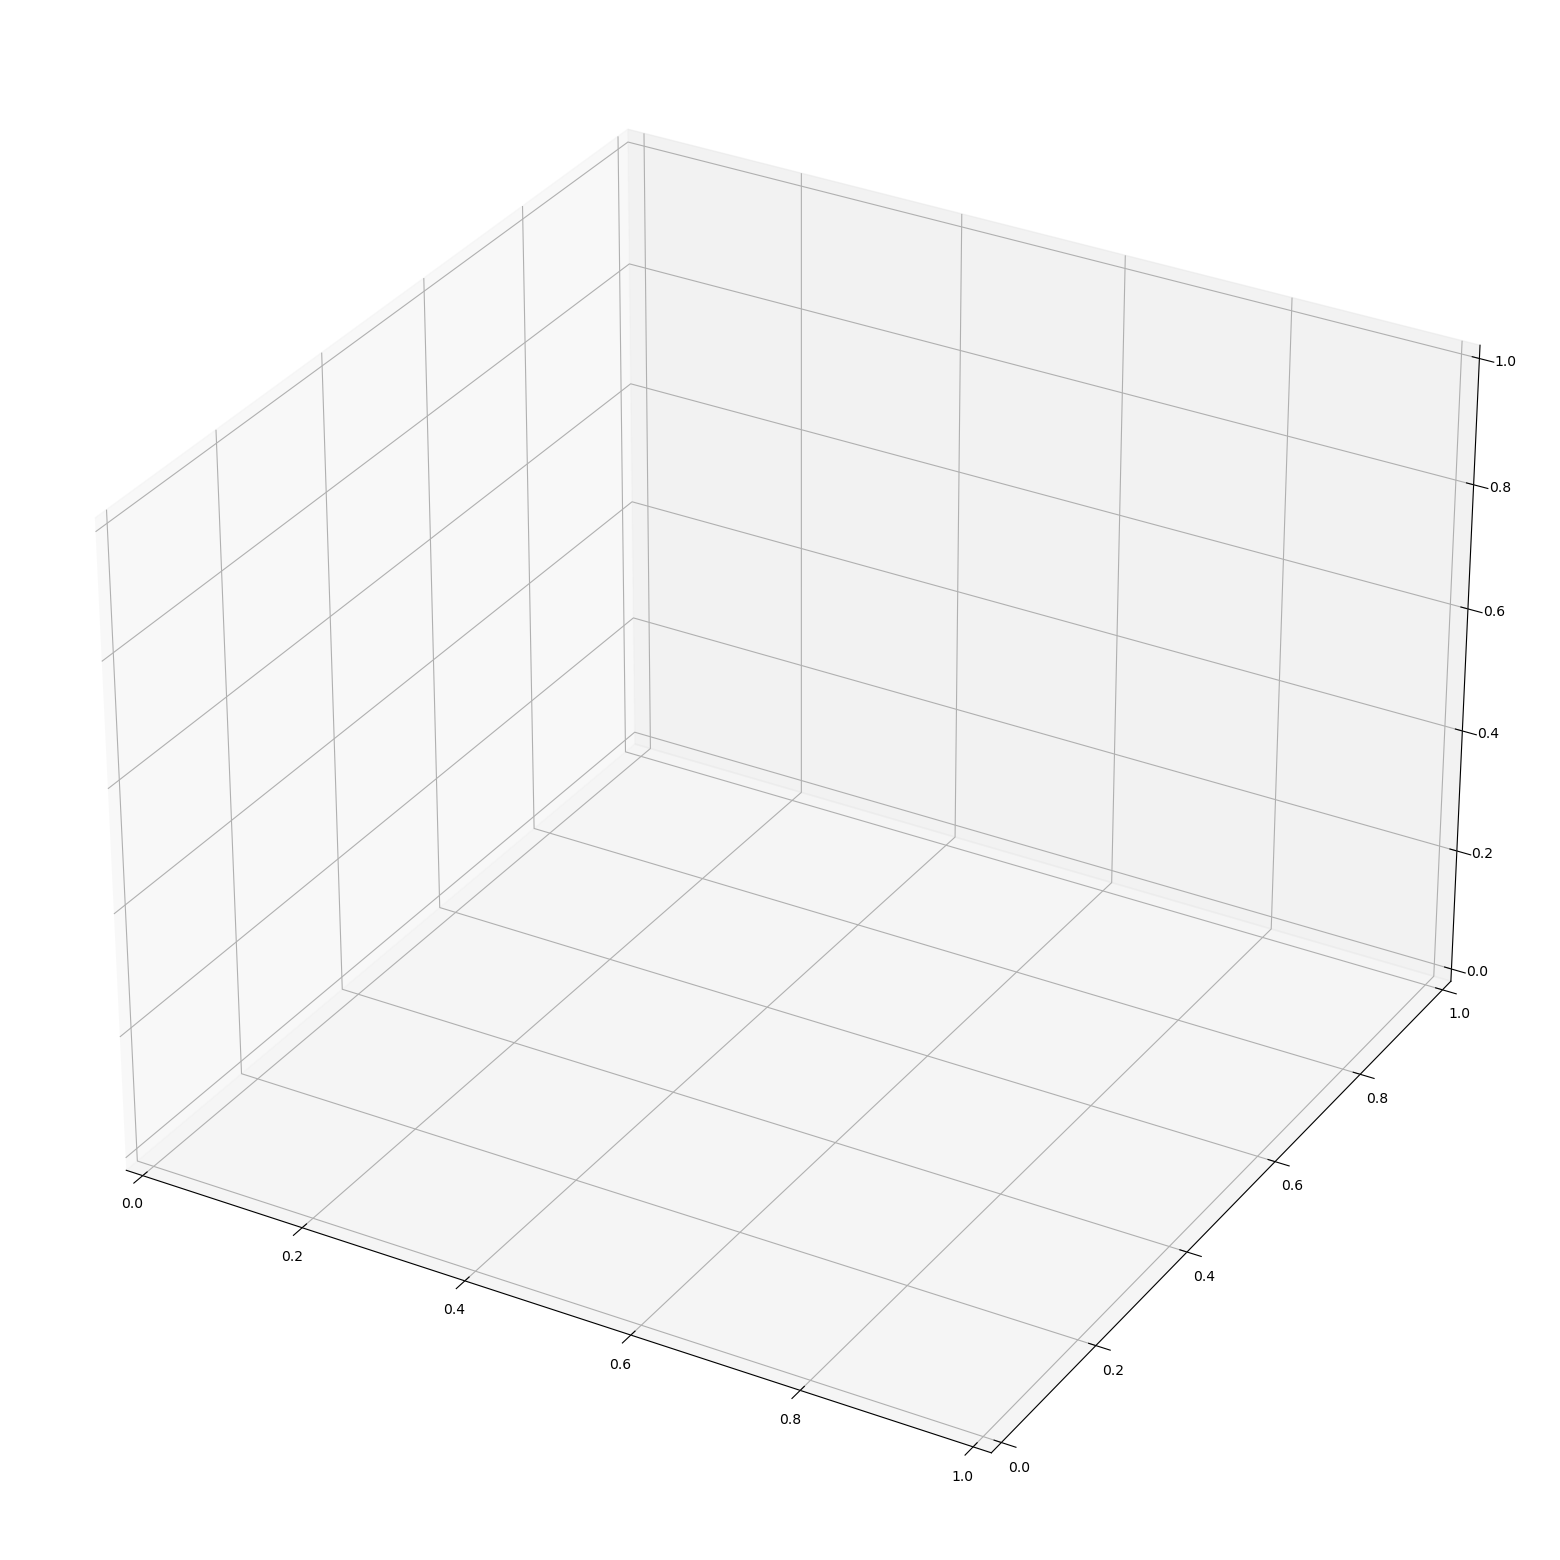

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example values for x and y axes
#x = np.linspace(-5, 5, 100)
#y = np.linspace(-5, 5, 100)
x = np.linspace(xmin, xmax, N+1)
t = np.linspace(0, T, M+1)
X, Y = np.meshgrid(x,t)
print(len(x))
print(len(t))
# Example matrix of values for the vertical axis
Z = np.array(Wmatrix)
print(np.shape(Z))
# Create 3D figure
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(111, projection='3d')

# Plot surface with X, Y, and Z values
#ax.plot_surface(X, Y, Z, cmap='viridis')
#ax.scatter(X, Y, Z)#, cmap='viridis')
ax.plot_wireframe(X, Y, Z)
# Add axis labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('w')
ax.set_title('Maturity = 0.5 year and Strike = 1900')

# Manually adjust the viewing angle
ax.view_init(30,100)

# Show the plot
plt.show()


In [18]:
D = np.empty((N))

In [7]:

start_time = time.time()

L = np.empty((N))
U = np.empty((N))
D = np.empty((N))
B = np.empty((N))


exp_n = np.zeros(N)
exp_p = np.zeros(N)

ei_n = np.zeros(N)
ei_p = np.zeros(N)

A = np.zeros(M)
r = np.zeros(M)
q = np.zeros(M)

omega = np.log(1-theta*nu-sig*sig*nu/2)/nu

cn = Dt/(lambda_n*nu*Dx)
cp = Dt/(lambda_p*nu*Dx)

c = Dt/nu

Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx)

def sigma_2(Y,Dx, lambda_p, lambda_n,v):
    #sig = integrate.quad(lambda y: y**2*k(y), -np.inf, -dx)[0]
    #sig += integrate.quad(lambda y: y**2*k(y), dx, np.inf)[0] 
    
    sig = (-(lambda_p*Dx)**(1-Y)*np.exp(-lambda_p*Dx)+(1-Y)*(g1(0)-g1(lambda_p*Dx)))*lambda_p**(Y-2)/v
    sig+= (-(lambda_n*Dx)**(1-Y)*np.exp(-lambda_n*Dx)+(1-Y)*(g1(0)-g1(lambda_n*Dx)))*lambda_n**(Y-2)/v
    
    return sig


Bn = Dt*(1-np.exp(-lambda_n*Dx))/(nu*lambda_n*Dx)
print(Bn)
Bp = Dt*(1-np.exp(-lambda_p*Dx))/(nu*lambda_p*Dx) # sur de la formule 
print(Bp)
#Bp is for U
sigma2_dx = sigma_2(Y,Dx, lambda_p, lambda_n,nu)
#Bp  = sigma2_dx*Dt *(1/(2*Dx**2)-1/(2*Dx))
print(Bp)          
#Bn is for L
#Bn  = sigma2_dx*Dt *(1/(2*Dx**2)+1/(2*Dx))
print(Bn)
    
x = np.empty(N+1)
W = np.empty(N+1)
Wmatrix=[]

for i in range(N+1):
    x[i] = np.log(xmin)+i*Dx
    if i == N:
        W[i] = 0
    else:
        if np.exp(x[i]) > K:
            W[i] = np.exp(x[i])-K
        else:
            W[i] = 0.0

Wmatrix.append(W.tolist())

for j in range(M-1, -1, -1):
    r[j] = rate
    q[j] = div
    A[j] = (r[j]-q[j]+omega)*Dt/Dx
    for i in range(1, N):
        B[i] = W[i]

    for i in range(1, N):
        if i == 1:
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
        elif i == N-1:
            L[i] = A[j] - Bn
            D[i] = 1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        else:
            L[i] =  A[j] - Bn
            D[i] =  1 + r[j]*Dt + Bp + Bn + Dt*((lambda_n\
            **Y*g2(i*Dx*lambda_n)+lambda_p**Y*g2((N-i)*Dx*lambda_p)))/nu
            U[i] = -A[j] - Bp
            for k in range(1, N-i):
                B[i] += lambda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*\
                         (g2_pos_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lambda_p**(1-Y)*Dx)*\
                         (g1_pos_diff[k])
            for k in range(1, i):
                B[i] += lambda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*\
                         (g2_neg_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lambda_n**(1-Y)*Dx)*\
                         (g1_neg_diff[k])
        B[i] += K*lambda_n**Y*g2(i*Dx*lambda_n) -\
        np.exp(x[i])*(lambda_n+1)**Y*g2(i*Dx*(lambda_n+1))

    tridiag(L,D,U,W,N-1)
    Wmatrix.append(W.tolist())

ir = 0
for i in range(N):
    if x[i] > np.log(S):
        ir = i 
        break

UOC = (W[ir]-W[ir-1])*(np.log(S)-x[ir-1])/Dx+ W[ir-1]



print("Option via explicit-implicit Finite Difference scheme: for strike %s the option premium \
is %6.4f" % (2000,UOC))
elapsed_time = time.time() - start_time
print('FFT execution time was %0.5f seconds' % elapsed_time)


0.05365849328638006
0.05353749040332997
0.05353749040332997
0.05365849328638006
Option via explicit-implicit Finite Difference scheme: for strike 2000 the option premium is 3.6064
FFT execution time was 63.74968 seconds


In [8]:
Dx=0.3
v =nu
s = (-(lambda_p*Dx)**(1-Y)*np.exp(-lambda_p*Dx)+(1-Y)*(g1(0)-g1(lambda_p*Dx)))*lambda_p**(Y-2)/v

s+= (-(lambda_n*Dx)**(1-Y)*np.exp(-lambda_n*Dx)+(1-Y)*(g1(0)-g1(lambda_n*Dx)))*lambda_n**(Y-2)/v
s

array([[0.09803877, 0.09803877, 0.09803877, ..., 0.09803877, 0.09803877,
        0.09803877],
       [0.09889865, 0.09889865, 0.09889865, ..., 0.09889865, 0.09889865,
        0.09889865],
       [0.09975843, 0.09975843, 0.09975843, ..., 0.09975843, 0.09975843,
        0.09975843],
       ...,
       [0.13307569, 0.13307569, 0.13307569, ..., 0.13307569, 0.13307569,
        0.13307569],
       [0.13298567, 0.13298567, 0.13298567, ..., 0.13298567, 0.13298567,
        0.13298567],
       [0.13284925, 0.13284925, 0.13284925, ..., 0.13284925, 0.13284925,
        0.13284925]])

In [9]:
sigma_2(Y,0.3, lambda_p, lambda_n,nu)

array([[0.09803877, 0.09803877, 0.09803877, ..., 0.09803877, 0.09803877,
        0.09803877],
       [0.09889865, 0.09889865, 0.09889865, ..., 0.09889865, 0.09889865,
        0.09889865],
       [0.09975843, 0.09975843, 0.09975843, ..., 0.09975843, 0.09975843,
        0.09975843],
       ...,
       [0.13307569, 0.13307569, 0.13307569, ..., 0.13307569, 0.13307569,
        0.13307569],
       [0.13298567, 0.13298567, 0.13298567, ..., 0.13298567, 0.13298567,
        0.13298567],
       [0.13284925, 0.13284925, 0.13284925, ..., 0.13284925, 0.13284925,
        0.13284925]])

/var/folders/pr/693wddvj41v3lzy50wnq69fc0000gn/T/ipykernel_10196/2335562303.py:5: RuntimeWarning: overflow encountered in exp
  price += [np.exp(x[int(i)])]


<function matplotlib.pyplot.show(close=None, block=None)>

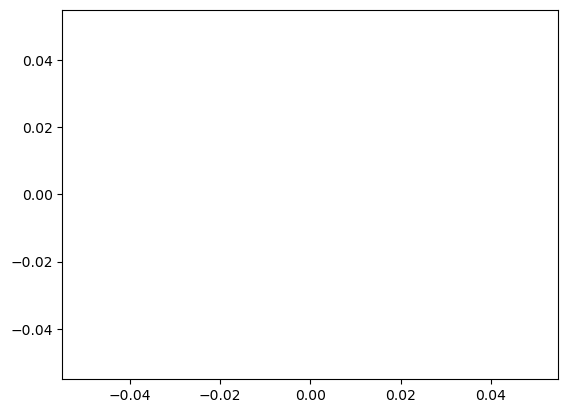

In [10]:
lbda = np.linspace(0,N,N)
FrFFT_Estimates_Given_lambda = []
price = []
for i in lbda:
    price += [np.exp(x[int(i)])]
    FrFFT_Estimates_Given_lambda += [W[int(i)]]
plt.plot(price,FrFFT_Estimates_Given_lambda)
plt.show